## Inicialización

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
#Se crea el generador de imagenes
datagen = ImageDataGenerator(rescale=1/255)

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
#Se cargan imagenes
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=931106) 

Found 7591 validated image filenames.


In [5]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Se encontraron 7,591 imágenes.

In [6]:
#Se pasan las imagenes a la variable
images, age= next(datagen_flow)

In [7]:
#Información features
images.shape

(32, 224, 224, 3)

In [8]:
age

array([34, 14,  4, 26, 12, 32, 39, 51,  2, 47, 32, 25, 76, 15, 29, 36, 59,
       47, 50, 51, 30, 36, 45, 33, 18, 35, 34, 25, 17, 19, 39, 18])

Se muestran las edades del paquete de imagenes

In [9]:
#Se carga el archivo
target = pd.read_csv("/datasets/faces/labels.csv")

Se puede apreciar que el dataset contiene 2 columnas con 7,591 filas. Las columnas contienen el tipo de valor adecuado. La columna `file_name` será eliminada, debido a que para fines del proyecto no es necesaria.

In [10]:
#Se toma columna real_age
target = target["real_age"]

In [11]:
#Se muestran cambios en la variable
target

0        4
1       18
2       80
3       50
4       17
        ..
7586    14
7587    37
7588    28
7589    20
7590    47
Name: real_age, Length: 7591, dtype: int64

In [12]:
target.isna().sum()

0

No se encuentra valores ausentes.

## EDA

### Distribución images

Edad 34


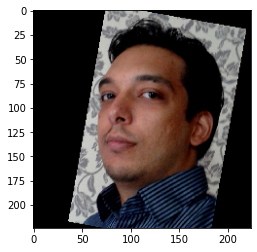

Edad 14


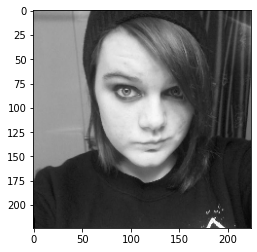

Edad 4


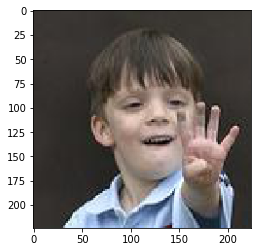

Edad 26


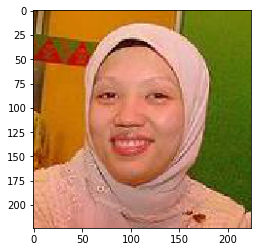

Edad 12


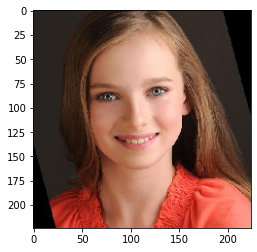

Edad 32


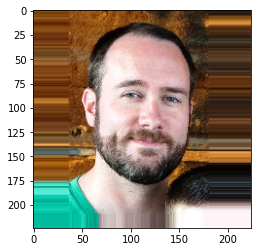

Edad 39


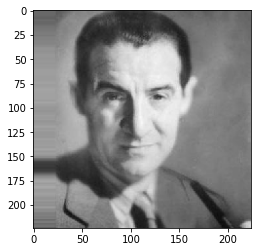

Edad 51


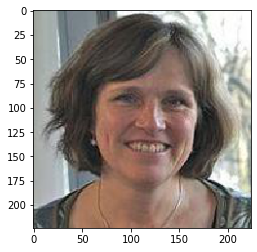

Edad 2


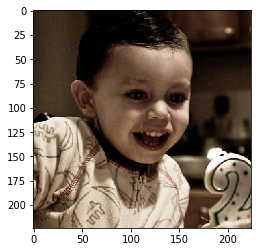

Edad 47


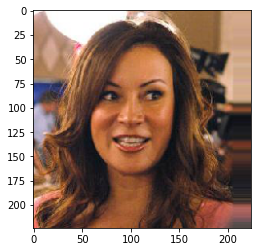

In [13]:
for i in range(0, 10):
    print("Edad",age[i])
    plt.imshow(images[i])
    plt.show()

Se aprecia que las edades correspondes con las imagenes.

### Distribución target

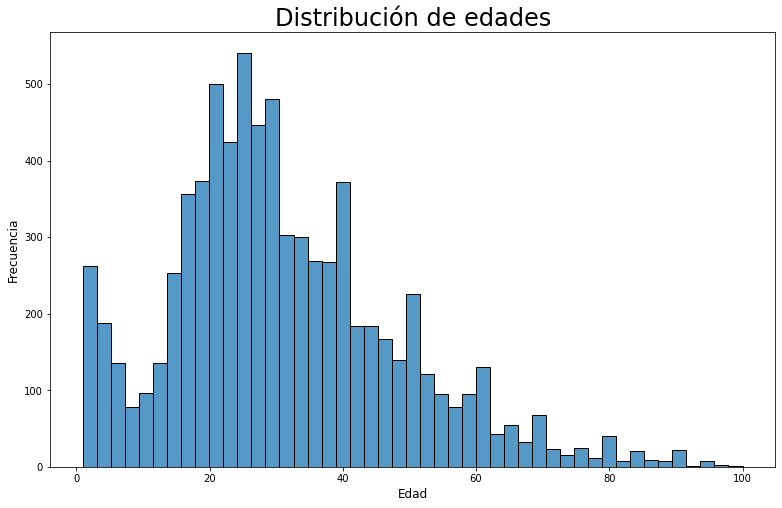

In [14]:
fig, ax = plt.subplots(figsize = (13, 8))
sns.histplot(target, ax = ax)
ax.set_title( "Distribución de edades" , size = 24 )
ax.set_xlabel( "Edad" , size = 12 )
ax.set_ylabel( "Frecuencia" , size = 12 )
plt.show()

Se aprecia una distribución casi normal. Se puede ver que en su mayoriía gente entre 20 y 30 años, son las que más se toman fotos. En cambio, apartir de los 40 años la frecuencia cae considerablemente. 

### Conclusiones

Debido a la tendencia de la gente joven para tomarse fotos, se espera que en el modelo se le facilitará más identificar a la gente entre 20 y 40 años.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [15]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.25)


    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=931106) 

    return train_gen_flow

In [17]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    valid_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.25)
   

    test_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=931106) 

    return test_gen_flow

In [18]:

def create_model(input_shape):
    """
    Define el modelo
    """  
    optimizer = Adam(lr=0.001)
    backbone = ResNet50(
    input_shape=input_shape,
    weights='imagenet', 
    include_top=False)
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(
        optimizer= optimizer,
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
                )
    return model

In [19]:
def train_model(model, train_data, test_data, 
                batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(
        train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
         validation_steps=validation_steps,
        verbose=2
    )
    
    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [20]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

238/238 - 36s - loss: 4.6617 - mean_absolute_error: 4.6547
Test MAE: 4.6547

## Conclusiones

El modelo se ajustó bastante al entrenamiento con un error absoluto medio en el conjunto de prueba de 4.65. Esto quiere decir que en las predicciones tienen un error de 5 años en promedio.
